## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [117]:
#!pip install -U torch==1.10 torchtext torchvision

In [118]:
from tqdm.notebook import tqdm

In [119]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [120]:
import torch
torch.__version__

'1.11.0+cu113'

In [121]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

#! pip  install subword-nmt
#! pip install nltk
#! pip install torchtext

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim

#import torchtext
#from torchtext.datasets import TranslationDataset, Multi30k
#from torchtext.data import Field, BucketIterator
#from torchtext.datasets import TranslationDataset, Multi30k
#from torchtext.data import Field, BucketIterator

#import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#from nltk.tokenize import WordPunctTokenizer
#from subword_nmt.learn_bpe import learn_bpe
#from subword_nmt.apply_bpe import BPE


In [123]:
#from nltk.translate.bleu_score import corpus_bleu


In [124]:
import numpy as np

In [125]:
df = pd.read_csv(r'data\recsys-in-practice\train_joke_df.csv')

df.head(2)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17


In [126]:
#rating = df['Rating'].values
#print(np.min(rating), np.max(np.abs(rating)), np.max(np.abs(rating)))

#rating_norm = (rating - np.min(rating)) / (np.max(rating) - np.min(rating))
#rating_norm = rating / np.max(np.abs(rating))
#print(np.min(rating_norm), np.max(rating_norm))

#df['Rating'] = rating_norm

In [127]:
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)
df.head(2)

,UID,JID,Rating
0,1,1,-7.82
1,1,2,8.79


In [128]:
df_gr = df.groupby(by='UID', as_index=False).agg({'JID':list, 'Rating':list})
df_gr

,UID,JID,Rating
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...","[-7.82, 8.79, -9.66, -8.16, -7.52, -8.5, -9.85..."
1,2,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...","[4.08, -0.29, 6.36, 4.37, -9.66, -0.73, -5.34,..."
2,3,"[5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 2...","[9.03, 9.27, 9.03, 9.27, 7.33, 7.57, 9.37, -6...."
3,4,"[2, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 1...","[8.35, 1.8, -2.82, 6.21, 1.84, 7.33, 6.31, 8.1..."
4,5,"[1, 2, 3, 4, 7, 9, 11, 12, 13, 14, 15, 16, 18,...","[8.5, 4.61, -4.17, -5.39, 7.04, -0.44, 8.25, 6..."
...,...,...,...
24978,24979,"[1, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18...","[0.44, 2.33, 6.75, -8.79, -0.53, -0.53, 5.63, ..."
24979,24980,"[2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 1...","[-8.16, 8.59, 9.08, 0.87, -8.93, -3.5, 5.78, -..."
24980,24981,"[5, 8, 13, 14, 17, 18, 20, 26, 28, 32, 35, 36,...","[-7.77, -6.75, -6.46, -1.65, -6.99, 7.23, -6.9..."
24981,24982,"[5, 7, 8, 13, 15, 16, 17, 18, 19, 20, 21, 28, ...","[-9.71, 4.56, -8.3, -9.47, 3.45, -0.92, -4.51,..."


In [129]:
len(df_gr.values[0][1])

62

In [130]:
len(df_gr.values[0][2])

62

In [131]:
max_joke_id = np.max(np.unique(df['JID']))
sos_token = max_joke_id + 1
eos_token = max_joke_id + 2
pad_token = max_joke_id + 3
mask_token = max_joke_id + 4
max_joke_id, sos_token, eos_token, pad_token, mask_token

(100, 101, 102, 103, 104)

In [132]:
max_len = np.max(df_gr['JID'].apply(len))
min_len = np.min(df_gr['JID'].apply(len))
min_len, max_len

(18, 95)

In [133]:
seq_len = max_len + 2

In [134]:
trg_seq_len = 5

In [135]:
for row in df_gr.values:
    
    ext_len = max_len - len(row[1])
    
    row[1].insert(0, sos_token)
    row[1].extend([pad_token] * ext_len)
    row[1].append(eos_token)
    
    
    row[2].insert(0, 0)
    row[2].extend([0] * ext_len)
    row[2].append(0)
    
max_len = np.max(df_gr['JID'].apply(len))
min_len = np.min(df_gr['JID'].apply(len))
print(min_len, max_len)
df_gr

97 97


,UID,JID,Rating
0,1,"[101, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 1...","[0, -7.82, 8.79, -9.66, -8.16, -7.52, -8.5, -9..."
1,2,"[101, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, ...","[0, 4.08, -0.29, 6.36, 4.37, -9.66, -0.73, -5...."
2,3,"[101, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, ...","[0, 9.03, 9.27, 9.03, 9.27, 7.33, 7.57, 9.37, ..."
3,4,"[101, 2, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, ...","[0, 8.35, 1.8, -2.82, 6.21, 1.84, 7.33, 6.31, ..."
4,5,"[101, 1, 2, 3, 4, 7, 9, 11, 12, 13, 14, 15, 16...","[0, 8.5, 4.61, -4.17, -5.39, 7.04, -0.44, 8.25..."
...,...,...,...
24978,24979,"[101, 1, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 1...","[0, 0.44, 2.33, 6.75, -8.79, -0.53, -0.53, 5.6..."
24979,24980,"[101, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, ...","[0, -8.16, 8.59, 9.08, 0.87, -8.93, -3.5, 5.78..."
24980,24981,"[101, 5, 8, 13, 14, 17, 18, 20, 26, 28, 32, 35...","[0, -7.77, -6.75, -6.46, -1.65, -6.99, 7.23, -..."
24981,24982,"[101, 5, 7, 8, 13, 15, 16, 17, 18, 19, 20, 21,...","[0, -9.71, 4.56, -8.3, -9.47, 3.45, -0.92, -4...."


In [136]:
df_gr.values[0][1][-10:]

[103, 103, 103, 103, 103, 103, 103, 103, 103, 102]

In [137]:
df_gr.values[0][2][-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [138]:
tokens = df_gr.values[0][1]


count = np.random.randint(1, 5)
indices = np.random.choice(np.where(tokens <= max_joke_id)[0], count)

x = torch.tensor(tokens)
x[indices] = mask_token
x

tensor([101,   1,   2, 104,   4,   5, 104,   7,   8,   9,  10,  12,  13,  14,
         15,  16,  17,  18,  20,  21, 104,  23,  24,  26,  27,  28,  29,  30,
         32,  33,  35,  36,  37,  38,  41,  42,  43,  44,  45,  47,  48,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  61,  62,  63,  64,  66,
         67,  68,  69,  70,  78,  82,  97, 103, 103, 103, 103, 103, 103, 103,
        103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,
        103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 102])

In [139]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [140]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
            
    def __getitem__(self, index: int):    
        tokens = self.df.values[index][1]
        ratings = self.df.values[index][2]

        count = trg_seq_len#np.random.randint(1, 5)
        indices = np.array(np.random.choice(np.where(tokens <= max_joke_id)[0], count), dtype=int)

        #todo
        indices = [10, 20, 30, 40, 50]
        #print(indices)
        tokens_src = torch.tensor(tokens, device=device)
        tokens_trg = tokens_src[indices].detach().clone().to(device)
        tokens_src[indices] = mask_token
        
        ratings_src = torch.tensor(ratings, device=device)
        ratings_trg = ratings_src[indices].detach().clone().to(device)
        ratings_src[indices] = 0

        return tokens_src, tokens_trg, ratings_src, ratings_trg
    
    def __len__(self):
        return len(self.df)

In [141]:
ds = FeaturesDataset(df_gr)

In [142]:
ds[0]

(tensor([101,   1,   2,   3,   4,   5,   6,   7,   8,   9, 104,  12,  13,  14,
          15,  16,  17,  18,  20,  21, 104,  23,  24,  26,  27,  28,  29,  30,
          32,  33, 104,  36,  37,  38,  41,  42,  43,  44,  45,  47, 104,  50,
          51,  52,  53,  54,  55,  56,  57,  58, 104,  61,  62,  63,  64,  66,
          67,  68,  69,  70,  78,  82,  97, 103, 103, 103, 103, 103, 103, 103,
         103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,
         103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 102],
        device='cuda:0'),
 tensor([10, 22, 35, 48, 59], device='cuda:0'),
 tensor([ 0.0000, -7.8200,  8.7900, -9.6600, -8.1600, -7.5200, -8.5000, -9.8500,
          4.1700, -8.9800,  0.0000, -6.7500, -7.1800,  8.4500, -7.1800, -7.5200,
         -7.4300, -9.8100, -9.8500, -9.3700,  0.0000, -4.3700, -9.8100,  1.1200,
          7.8200,  2.8600,  9.1300, -7.4300, -4.0800, -9.0800,  0.0000,  4.9500,
         -9.1700, -8.4000, -8.1100, -9.1300, -9.0300,

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [143]:
batch_size=7

for tokens_src, tokens_trg, ratings_src, ratings_trg in torch.utils.data.DataLoader(ds, batch_size= batch_size):
    #print(x, y)
    break
    
tokens_src.shape, tokens_trg.shape, ratings_src.shape, ratings_trg.shape

(torch.Size([7, 97]),
 torch.Size([7, 5]),
 torch.Size([7, 97]),
 torch.Size([7, 5]))

In [144]:
(torch.rand((97, 7, 256)) * torch.rand((97, 7)).unsqueeze(-1)).shape

torch.Size([97, 7, 256])

In [145]:
torch.rand((97, 7)).unsqueeze(-1).shape

torch.Size([97, 7, 1])

In [146]:

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, tokens_src, tokens_trg, ratings_src, ratings_trg):
        
        #src = [src sent len, batch size]
        #print('tokens_src',tokens_src.shape)
        
        # Compute an embedding from the src data and apply dropout to it
        embedded_src = self.embedding(tokens_src)# <YOUR CODE HERE>
        embedded_trg = self.embedding(tokens_trg)
        
        embedded_src = self.dropout(embedded_src)
        embedded_trg = self.dropout(embedded_trg)
        
        #print('embedded_src',embedded_src.shape)
        
        #todo
        embedded_src = embedded_src * ratings_src.unsqueeze(-1)
        #embedded_trg = embedded_trg * ratings_src.unsqueeze(-1)
        
        #embedded = torch.cat([embedded_src, embedded_trg], dim=2)
        #print('embedded',embedded.shape)#,'ratings_src', ratings_src.shape)
        
        
        output, (hidden, cell) = self.rnn(embedded_src)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE> 
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [147]:

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


In [148]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, ratings_range=[-10, 10]):
        super().__init__()
        
        self.y_range = ratings_range
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        inp_shape = decoder.hid_dim
        
        self.linear = nn.Sequential(
                nn.Linear(inp_shape, trg_seq_len, dtype=torch.float),
                nn.Dropout(0.66),
                nn.BatchNorm1d(trg_seq_len, dtype=torch.float),
                nn.ReLU(inplace=True)
                )
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, tokens_src, tokens_trg, ratings_src, ratings_trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = tokens_trg.shape[1]
        max_len = tokens_trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(tokens_src, tokens_trg, ratings_src, ratings_trg)
        
        #first input to the decoder is the <sos> tokens
        input = tokens_trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (tokens_trg[t] if teacher_force else top1)
        
        hidden = hidden.transpose(0,1).sum(dim=1)
        hidden = self.linear(hidden)
        
        return outputs, torch.sigmoid(hidden) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


In [149]:
PAD_IDX = pad_token#TRG.vocab.stoi['<pad>']

In [150]:
INPUT_DIM = 105
OUTPUT_DIM = 105
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

batch_size=7
for tokens_src, tokens_trg, ratings_src, ratings_trg in torch.utils.data.DataLoader(ds, batch_size=512):
    #print(x, y)
    break
    
#print(x.T.shape)
#hidden, cell = model.encoder(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T )
#print(hidden.shape, cell.shape)  

#prediction, hidden2, cell2 = model.decoder(x, hidden, cell, indices)

#print(prediction.shape, hidden2.shape, cell2.shape)
output, hidden = model(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T)
#print(tokens_src.T.shape, tokens_trg.T.shape)
print(output.shape, hidden.shape)



out = output[1:].view(-1, output.shape[-1])
#print(out.shape)
trg = (tokens_trg.T)[1:].contiguous().view(-1)
#print(trg.shape)

nn.CrossEntropyLoss(ignore_index = PAD_IDX)(out, trg)

torch.Size([5, 512, 105]) torch.Size([512, 5])


tensor(4.6509, device='cuda:0', grad_fn=<NllLossBackward0>)

In [151]:
hidden.shape

torch.Size([512, 5])

In [152]:
ratings_trg.shape

torch.Size([512, 5])

In [153]:
def RMSE_loss(prediction, target):
    return torch.sqrt(nn.MSELoss()(prediction, target))

In [154]:
RMSE_loss(hidden, ratings_trg)

tensor(5.2846, device='cuda:0', grad_fn=<SqrtBackward0>)

In [155]:
hidden, ratings_trg

(tensor([[1.8201, 1.7396, 0.2868, 2.1593, 5.4913],
         [1.8201, 1.7396, 0.2868, 0.0682, 0.0000],
         [1.8201, 8.7066, 0.2868, 0.0682, 0.0000],
         ...,
         [0.0000, 1.7396, 0.2868, 0.0682, 0.0000],
         [0.7158, 1.7396, 0.2868, 0.0682, 0.0000],
         [1.8201, 1.7396, 0.0000, 0.0682, 0.0000]], device='cuda:0',
        grad_fn=<AddBackward0>),
 tensor([[-4.7600,  1.5000,  5.0500, -0.1000,  2.8200],
         [ 6.7500,  8.3500,  0.7300, -4.9000,  0.1000],
         [-7.8600,  7.2800,  7.3300,  9.0800,  0.0000],
         ...,
         [-0.6300, -2.9100,  2.8200, -0.3900, -6.5000],
         [-7.5700, -1.8000,  0.9700, -1.6000,  0.0000],
         [-1.5500,  1.0200,  1.7000,  0.0000,  0.0000]], device='cuda:0'))

In [156]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        


In [157]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [158]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, (tokens_src, tokens_trg, ratings_src, ratings_trg) in enumerate(tqdm(iterator)):
        
        optimizer.zero_grad()
        
        #output = model(src, trg)
        output, hidden = model(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T)
        
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        tokens_trg = tokens_trg.T[1:].contiguous().view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss1 = criterion(output, tokens_trg)
        loss2 = RMSE_loss(hidden, ratings_trg)        
        loss = loss1# + loss2
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.cpu().data.numpy()
        
        history.append(loss.cpu().data.numpy())
        #if (i+1)%10==0:
        #    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        #    clear_output(True)
        #    ax[0].plot(history, label='train loss')
        #    ax[0].set_xlabel('Batch')
        #    ax[0].set_title('Train loss')
        #    if train_history is not None:
        #        ax[1].plot(train_history, label='general train history')
        #        ax[1].set_xlabel('Epoch')
        #    if valid_history is not None:
        #        ax[1].plot(valid_history, label='general valid history')
        #    plt.legend()
            
        #    plt.show()

        
    return epoch_loss / len(iterator)

In [159]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, (tokens_src, tokens_trg, ratings_src, ratings_trg) in enumerate(tqdm(iterator)):#

            #output = model(src, trg, 0) #turn off teacher forcing
            output, hidden = model(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T)
            
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = tokens_trg.T[1:].contiguous().view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            #loss2 = RMSE_loss(hidden, ratings_trg)
            
            epoch_loss += loss.cpu().data.numpy()
            #epoch_loss += loss2.cpu().data.numpy()
        
    return epoch_loss / len(iterator)

In [160]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [161]:
def start_train(model, optimizer, criterion, n_epochs, train_history, valid_history):
    CLIP = 1
    best_valid_loss = float('inf')
    
    
    for epoch in tqdm(range(n_epochs)):

        start_time = time.time()

        #todo ds_test change to ds_train
        train_loss = train(model, DataLoader(ds_test, batch_size= 512), optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, DataLoader(ds_test, batch_size= 512), criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s |\tTrain Loss: {train_loss:.3f} |\t Val. Loss: {valid_loss:.3f} ')
        
    
    plt.plot(train_history, label='general train history')
    plt.plot(valid_history, label='general valid history')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

__Let's take a look at our network quality__:

In [162]:
N_EPOCHS = 10

In [163]:
#baseline

In [164]:
df_train, df_test = train_test_split(df_gr.loc[:1000], test_size=0.2, random_state=42)
len(df_train), len(df_test)

(800, 201)

In [165]:
ds_train = FeaturesDataset(df_train)
ds_test = FeaturesDataset(df_test)

In [166]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [167]:
INPUT_DIM = 105
OUTPUT_DIM = 105
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

N_EPOCHS = 100

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device, ratings_range=(-10, 10)).to(device)
print(model)
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []


optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

#score_baseline, original_text_baseline, generated_text_baseline = bleu_score(model)
#score_baseline

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(105, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(105, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=105, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=5, bias=True)
    (1): Dropout(p=0.66, inplace=False)
    (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
)
The model has 7,466,616 trainable parameters


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 0s |	Train Loss: 1.877 |	 Val. Loss: 1.780 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 0s |	Train Loss: 2.147 |	 Val. Loss: 1.789 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 0s |	Train Loss: 1.858 |	 Val. Loss: 1.798 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 0s |	Train Loss: 1.672 |	 Val. Loss: 1.785 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05 | Time: 0m 0s |	Train Loss: 2.197 |	 Val. Loss: 1.680 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06 | Time: 0m 0s |	Train Loss: 2.188 |	 Val. Loss: 1.760 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07 | Time: 0m 0s |	Train Loss: 1.847 |	 Val. Loss: 2.048 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08 | Time: 0m 0s |	Train Loss: 1.851 |	 Val. Loss: 2.030 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09 | Time: 0m 0s |	Train Loss: 1.656 |	 Val. Loss: 1.922 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10 | Time: 0m 0s |	Train Loss: 1.841 |	 Val. Loss: 1.697 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11 | Time: 0m 0s |	Train Loss: 1.630 |	 Val. Loss: 1.543 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12 | Time: 0m 0s |	Train Loss: 1.806 |	 Val. Loss: 1.683 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13 | Time: 0m 0s |	Train Loss: 1.759 |	 Val. Loss: 1.713 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14 | Time: 0m 0s |	Train Loss: 2.123 |	 Val. Loss: 2.008 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15 | Time: 0m 0s |	Train Loss: 1.928 |	 Val. Loss: 1.591 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16 | Time: 0m 0s |	Train Loss: 2.069 |	 Val. Loss: 1.488 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17 | Time: 0m 0s |	Train Loss: 1.934 |	 Val. Loss: 1.890 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18 | Time: 0m 0s |	Train Loss: 2.021 |	 Val. Loss: 1.725 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19 | Time: 0m 0s |	Train Loss: 1.627 |	 Val. Loss: 1.697 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20 | Time: 0m 0s |	Train Loss: 1.616 |	 Val. Loss: 1.996 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21 | Time: 0m 0s |	Train Loss: 2.092 |	 Val. Loss: 1.531 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22 | Time: 0m 0s |	Train Loss: 1.652 |	 Val. Loss: 1.641 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23 | Time: 0m 0s |	Train Loss: 1.866 |	 Val. Loss: 1.973 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24 | Time: 0m 0s |	Train Loss: 2.093 |	 Val. Loss: 1.653 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25 | Time: 0m 0s |	Train Loss: 1.749 |	 Val. Loss: 1.525 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26 | Time: 0m 0s |	Train Loss: 1.568 |	 Val. Loss: 1.701 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27 | Time: 0m 0s |	Train Loss: 1.745 |	 Val. Loss: 1.515 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28 | Time: 0m 0s |	Train Loss: 1.936 |	 Val. Loss: 1.646 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29 | Time: 0m 0s |	Train Loss: 1.558 |	 Val. Loss: 1.614 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30 | Time: 0m 0s |	Train Loss: 1.757 |	 Val. Loss: 1.838 


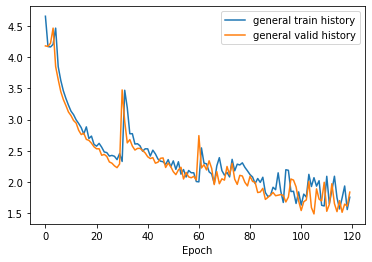

In [193]:

optimizer = optim.Adam(model.parameters(), lr=1e-3)
start_train(model, optimizer, criterion, 30, train_history, valid_history)


In [194]:
generated_text = []

with torch.no_grad():
    for tokens_src, tokens_trg, ratings_src, ratings_trg in tqdm(DataLoader(ds_test, batch_size= 1)):  
        output, hidden = model(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T, 0) #turn off teacher forcing
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        output = output.argmax(dim=-1)        
        generated_text.append(output.detach().cpu().numpy().T)
        
        break

  0%|          | 0/201 [00:00<?, ?it/s]

In [198]:
generated_text

[array([[ 0, 25, 39, 51, 63]], dtype=int64)]

In [197]:
tokens_trg

tensor([[13, 26, 39, 54, 66]], device='cuda:0')

In [ ]:
for tokens_src, tokens_trg, ratings_src, ratings_trg in torch.utils.data.DataLoader(ds, batch_size=1):
    #print(x, y)
    break
    

output, hidden = model(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T)
hidden, ratings_trg, RMSE_loss(hidden, ratings_trg)

In [ ]:
output, hidden = model(tokens_src.T, tokens_trg.T, ratings_src.T, ratings_trg.T)
hidden, ratings_trg, RMSE_loss(hidden, ratings_trg)

In [ ]:
hidden, ratings_trg

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

In [ ]:
assert False

## Эксперимент 1
Попробуем изменить количество слоев и размерности векторов базовой модели

In [ ]:
# Увеличиваем размерность

INPUT_DIM = 105
OUTPUT_DIM = 105
ENC_EMB_DIM = 1024
DEC_EMB_DIM = 1024
HID_DIM = 1024
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
print(model)
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

score_1, original_text_1, generated_text_1 = bleu_score(model)
score_1

При увелечении размерности эмбеддингов и скрытых слоёв до 1024 качество модели увеличилось, метрика BLEU выросла с 13 до 19

In [ ]:
#Добавляем слоев

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
print(model)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

score_2, original_text_2, generated_text_2 = bleu_score(model)
score_2

## Эксперимент 2 
Механизм внимания

In [ ]:
#week04_attention/practice1_04_seq2seq_nmt__with_attention.ipynb
class EncoderAtt(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden
    
    
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)
    
    
class DecoderAtt(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

class Seq2SeqAtt(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
import torch.nn.functional as F

In [ ]:
INPUT_DIM = 105
OUTPUT_DIM = 105

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2SeqAtt(enc, dec, device).to(device)


print(model)
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

score_att, original_text_att, generated_text_att = bleu_score(model)
score_att

При использовании внимания качество модели увеличилось, метрика BLEU выросла до 31

## Эксперимент 3
Трафнсформер

In [ ]:
from torch import Tensor
from torch.nn import Transformer
from timeit import default_timer as timer

In [ ]:
#https://pytorch.org/tutorials/beginner/translation_transformer.html

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)
    
    
    


SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [ ]:

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:

def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0
  
    for batch in train_dataloader:
        
        src = batch.src
        tgt = batch.trg
        
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0

    for batch in val_dataloader:
        
        src = batch.src
        tgt = batch.trg
        
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [ ]:

for epoch in range(1, N_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_iterator)
    end_time = timer()
    val_loss = evaluate(model, valid_iterator)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))



In [ ]:

# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


In [ ]:
EOS_IDX = SRC.vocab.stoi["<eos>"]
BOS_IDX = SRC.vocab.stoi["<sos>"]
EOS_IDX, BOS_IDX

In [ ]:
def get_text(x, TRG_vocab):
    text = []
    for token in x:
        try:
            text.append(TRG_vocab.itos[token])
        except Exception as ex:
            text.append('-')
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

In [ ]:
# actual function to translate input sentence into target language
def translate3(model: torch.nn.Module, src):
    model.eval()
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()

    res = get_text(tgt_tokens.cpu().numpy(), TRG.vocab)
    res = [x for x in res if x not in ["<sos>", "<eos>"]]
    return res

In [ ]:
original_text_trns = []
generated_text_trns = []

model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        
        src = batch.src
        tgt = batch.trg
        
        src = src.to(device)
        tgt = tgt.to(device)

        #tgt_input = tgt[:-1, :]

        #src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        #logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        #print(logits.shape)
        
        #print(logits.reshape(-1, logits.shape[-1]).shape)
        
        
        #tgt_out = tgt[1:, :]
        #print(tgt_out.reshape(-1).shape)
        
        #print(loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)).item())
        
        original_text_trns.extend([get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T])
        
        #print(tgt.shape)
        original = [get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T]
        
        for xx in src.cpu().numpy().T:
            generated_text_trns.append(translate3(model, torch.tensor(xx).view(-1, 1)))
        
        #generated = [get_text(x, TRG.vocab) for x in tgt_tokens.cpu().numpy().T]
        
        
        

In [ ]:
score_trns = corpus_bleu([[text] for text in original_text_trns], generated_text_trns) * 100
score_trns

При использовании модели трансформера качество увеличилось, метрика BLEU выросла до 31

In [ ]:
models = ['baseline', 'baseline 2', 'attention', 'transformer']
scores = [score_baseline, score_1, score_att, score_trns]
original = [original_text_baseline, original_text_1, original_text_2, original_text_att, original_text_trns]
generated = [generated_text_baseline, generated_text_1, generated_text_2, generated_text_att, generated_text_trns]

for i in range(0, 7500, 250):
    for score, model_name, orig, gen in zip(scores, models, original, generated):
        print('model:', model_name, 'score:', round(score, 2))    
        print(' '.join(orig[i]), '->\n', ' '.join(gen[i]), '\n', sep='')
    print('\n\n')

Метрики моделей с вниманием и с трансформерами совпадают, но кажется что перевод модели с трансформером более качественный, это особенно заметно на длинных предложениях